In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import ensemble
import pandas as pd
import numpy as np
import pandas as pd
import os
from sklearn.metrics import root_mean_squared_error


In [5]:
data_folder = 'processed_data'
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
data_frames = {file: pd.read_csv(os.path.join(data_folder, file)) for file in csv_files}

In [6]:
data_frames['games.csv']['home_team_win'] = (data_frames['games.csv']['home_team_goal'] > data_frames['games.csv']['away_team_goal']).astype(float)
data_frames['games.csv']['win_by']= (data_frames['games.csv']['home_team_goal'] - data_frames['games.csv']['away_team_goal']).abs().astype(int)

In [11]:
# Helper function to extract stats for a given player
def extract_player_stats(player_id, year, players_df):
    player_stats = players_df[(players_df['player_id'] == player_id) & (players_df['year'] == year)]
    
    # Check if player exists in the dataset for the given year
    # If not, look for the most recent data available
    while year > 2008 and player_stats.empty:
        year -= 1
        player_stats = players_df[(players_df['player_id'] == player_id) & (players_df['year'] == year)]
        
    if not player_stats.empty:
        return player_stats.drop(columns=['player_id', 'year']).iloc[0]
    else:
        return [0] * (players_df.shape[1] - 2)  # If no data, return zeroes

# Function to extract player stats for home and away players from a single game
def get_player_stats(game_row, players_df, is_home=True):
    player_stats = []
    year = game_row['year']
    
    # Extract stats for home and away players
    team = 'home' if is_home else 'away'
    for i in range(1, 12):
        player_id = game_row[f'{team}_player_{i}']
        player_stats.append(extract_player_stats(player_id, year, players_df))
    averages = [sum(x) / len(x) for x in zip(*player_stats)]
    player_stats.append(averages)
    return player_stats

In [12]:

home_players_formation = [f"home_player_X{i}" for i in range(1, 12)]
home_players_formation.extend([f"home_player_Y{i}" for i in range(1, 12)])
away_players_formation = [f"away_player_X{i}" for i in range(1, 12)]
away_players_formation.extend([f"away_player_Y{i}" for i in range(1, 12)])

# Load the datasets
games = data_frames['games.csv']
players = data_frames['players.csv']

# Prepare the features and labels (assuming 'home_team_win' as the target)
X = []
y = games['home_team_win']  # For example, you could have this as a binary target (1 for win, 0 for loss/draw)

# Extract features dynamically for each game
for index, game_row in games.iterrows():
    home_player_stats = get_player_stats(game_row, players, is_home=True)
    away_player_stats = get_player_stats(game_row, players, is_home=False)
    x_col = []
    x_col.extend([item for sublist in home_player_stats for item in sublist])
    x_col.extend([item for sublist in away_player_stats for item in sublist])
    # Adding formation data
    # x_col.extend([game_row[col] for col in home_players_formation])
    # x_col.extend([game_row[col] for col in away_players_formation]) 
    X.append(x_col) 

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)


In [17]:
# Train a model using RandomForestClassifier as an example
random_forest_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by filling with the mean
    ('classifier', RandomForestRegressor())
])

random_forest_pipeline.fit(X_train, y_train)
y_is_home_win = random_forest_pipeline.predict(X_test)

mse = root_mean_squared_error(y_test, y_is_home_win)
print(f'Mean Squared Error: {mse}')

#Mean Squared Error: 0.4727281752877052 without average

Mean Squared Error: 0.47339176063398547


In [8]:
def get_player_stats_test(game_row, players_df):
    player_stats = []
    
    # Extract stats for home players
    for i in range(1, 12):
        home_player_id = game_row[f'home_player_{i}']
        home_player_stats = players_df[(players_df['player_id'] == home_player_id)]
        
        if not home_player_stats.empty:
            home_player_stats = home_player_stats.drop(columns=['player_id'])
            player_stats.append(home_player_stats.iloc[0])
        else:
            player_stats.append([0] * (players_df.shape[1] - 1))  # If no data, append zeroes

    # Extract stats for away players
    for i in range(1, 12):
        away_player_id = game_row[f'away_player_{i}']
        away_player_stats = players_df[(players_df['player_id'] == away_player_id)]
         
        if not away_player_stats.empty:
            away_player_stats = away_player_stats.drop(columns=['player_id'])
            player_stats.append(away_player_stats.iloc[0])
        else:
            player_stats.append([0] * (players_df.shape[1] - 1))  # If no data, append zeroes

    return player_stats


    

In [14]:
predict_X = []

tests = data_frames["test.csv"]
player_mean = data_frames['players.csv'].groupby('player_id').mean().drop('year', axis=1).reset_index()

for index, test_row in tests.iterrows():
    player_stats = get_player_stats_test(test_row, player_mean)
    x_col = []
    x_col.extend([item for sublist in player_stats for item in sublist])
    # x_col.extend([test_row[col] for col in home_players_formation])
    # x_col.extend([test_row[col] for col in away_players_formation]) 
    predict_X.append(x_col) 

In [15]:
# saving RandomForestRegressor
random_forest_predict_X = random_forest_pipeline.predict(predict_X)
predict_X_np = np.array(random_forest_predict_X)

df = pd.DataFrame(predict_X_np, columns=['winner'])

df['winby'] = 1
df.to_csv('winner_random_forest.csv', index=False)


In [18]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

boosting_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by filling with the mean
    ('regressor', ensemble.GradientBoostingRegressor(**params))
])

boosting_pipeline.fit(X_train, y_train)
y_is_home_win = boosting_pipeline.predict(X_test)

mse = root_mean_squared_error(y_test, y_is_home_win)
print(f'Mean Squared Error: {mse}')
#Mean Squared Error: 0.4694489730421952 without average


Mean Squared Error: 0.4684405091481722


In [ ]:
boosting_pipeline["regressor"]

In [16]:
boosting_predict_Y = boosting_pipeline.predict(predict_X)
boosting_predict_Y = np.array(boosting_predict_Y)

df = pd.DataFrame(boosting_predict_Y, columns=['winner'])

df['winby'] = 1
# df.to_csv('winner_boost.csv', index=False)


In [25]:
players = ["overall_rating","potential","preferred_foot_left","preferred_foot_right", "attacking_work_rate","defensive_work_rate","crossing"]
feature_name = []
feature_name.extend([f'home_player_{i}_{rate}' for i in range(1, 12) for rate in players])
feature_name.extend([f'home_average_{rate}' for rate in players])
feature_name.extend([f'away_player_{i}_{rate}' for i in range(1, 12) for rate in players])
feature_name.extend([f'away_average_{rate}' for rate in players])


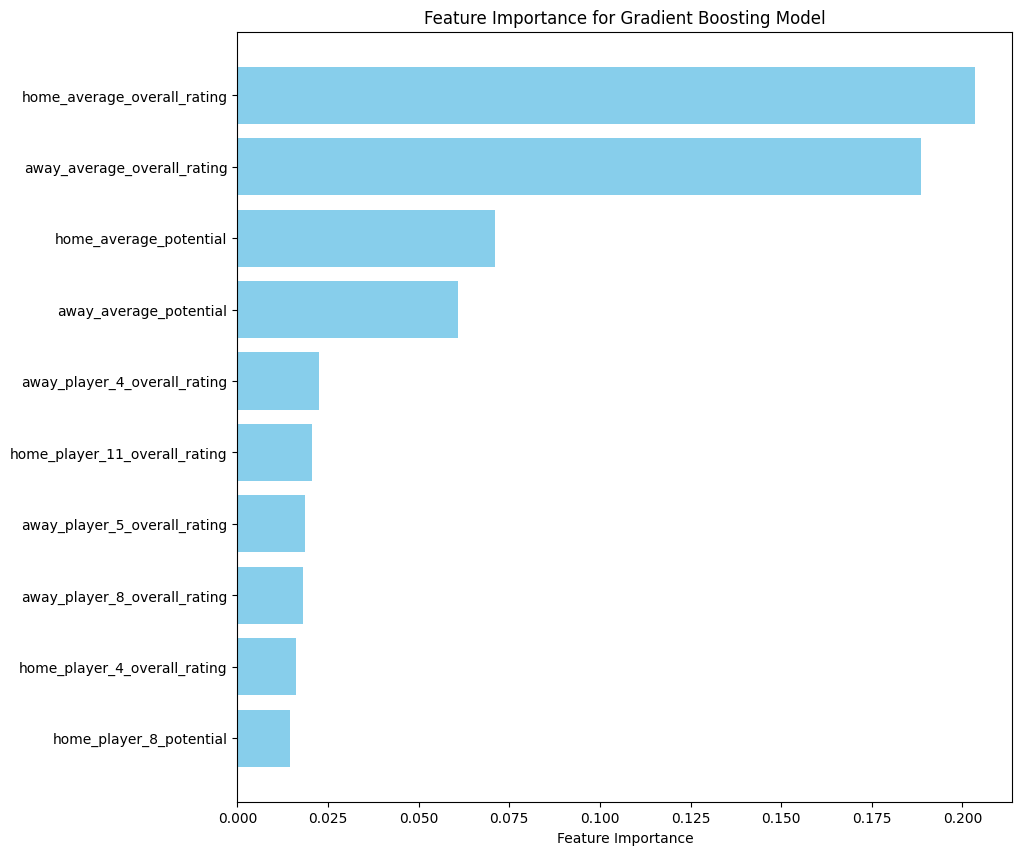

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances
feature_importances = boosting_pipeline.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame(feature_importances, index=feature_name, columns=['importance']).sort_values(by='importance', ascending=False).iloc[:10]

# Plot the sorted feature importances
plt.figure(figsize=(10, 10))
plt.barh(importance_df.index, importance_df['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Gradient Boosting Model")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()